This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [33]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/3

import pandas as pd
import numpy as np
import datetime as dt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [34]:
N=10**4+100
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
10095,1,1,20,3869200268,1214,6
10096,1,1,20,3869200268,1225,10
10097,1,0,80,3869200268,1226,9
10098,1,0,53,3869200268,1313,4


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [35]:
dx = data.copy()
x = dx['BX_COUNTER'].max()
print(x)

3563


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [36]:
data = pd.read_csv(file_name)
nbr_of_Orbit = data.loc[len(data)-1,'ORBIT_CNT'] - data.loc[0,'ORBIT_CNT']
TDC_MEAS_time=0
for i in range(len(data)): 
        TDC_MEAS_time+= data.loc[data.index[i], 'TDC_MEAS'] * 25 / 30. 
time = nbr_of_Orbit * data['BX_COUNTER'].max()* 25 + TDC_MEAS_time
print(pd.to_timedelta(time))

0 days 00:00:00.994734002


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [37]:
def absolute_time(data):
    result = []
    for i in range(len(data)):
        result.append(data.loc[data.index[i], 'TDC_MEAS'] * 25 / 30. + data.loc[data.index[i], 'BX_COUNTER'] * 25)
    return result
data['TIMENS'] = absolute_time(data)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIMENS
0,1,0,123,3869200167,2374,26,59371.666667
1,1,0,124,3869200167,2374,27,59372.500000
2,1,0,63,3869200167,2553,28,63848.333333
3,1,0,64,3869200167,2558,19,63965.833333
4,1,0,64,3869200167,2760,25,69020.833333
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,19061.666667
1310716,1,1,4,3869211171,763,11,19084.166667
1310717,1,0,64,3869211171,764,0,19100.000000
1310718,1,0,139,3869211171,769,0,19225.000000


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [27]:
dfg = data.groupby('TDC_CHANNEL')['HEAD'].sum()
dfg.nlargest(3)

TDC_CHANNEL
139    868
63     504
64     496
Name: HEAD, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [38]:
print("the number of non empty orbits:")
print(len(data['ORBIT_CNT'].value_counts()))

df_139 = data[data['TDC_CHANNEL']==139]
print("the number of unique orbits from TDC_CHANNEL=139:")
print(len(df_139['ORBIT_CNT'].value_counts()))
df_139

the number of non empty orbits:
11001
the number of unique orbits from TDC_CHANNEL=139:
10976


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIMENS
7,1,0,139,3869200167,2776,0,69400.0
15,1,1,139,3869200167,2797,0,69925.0
30,1,0,139,3869200167,3085,0,77125.0
39,1,0,139,3869200167,3186,0,79650.0
48,1,0,139,3869200168,23,0,575.0
...,...,...,...,...,...,...,...
1310650,1,1,139,3869211170,2959,0,73975.0
1310660,1,0,139,3869211170,3027,0,75675.0
1310685,1,0,139,3869211170,3230,0,80750.0
1310701,1,0,139,3869211171,21,0,525.0


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

TDC_CHANNEL  FPGA
1            0        1215
             1       28438
2            0        1602
             1       32669
3            0        1493
                     ...  
137          1          36
138          0          34
             1          36
139          0       75617
             1       32442
Name: HEAD, Length: 256, dtype: int64

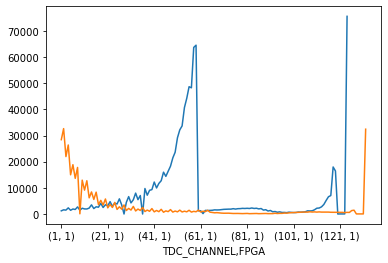

In [42]:
df_TDC_FPGA = data.groupby(['TDC_CHANNEL', 'FPGA'])['HEAD'].sum()
df_TDC_FPGA.groupby(['FPGA']).plot()
df_TDC_FPGA